# Censored Data, Outliers, and Ensemble MCMC Sampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import emcee

%matplotlib inline

Let's start our with our problem from last week: fitting a line to data.

### Our linear model from last week

In [2]:
# Our spectrum will be a line with a Gaussian absorption feature
def get_val(x, p):
    m, b = p
    
    return m*x + b

### Let's choose some data points

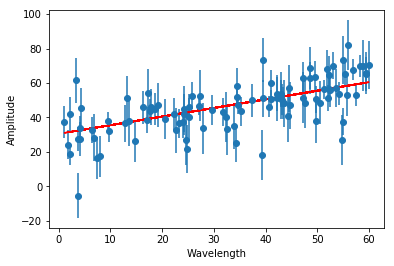

In [3]:
# The input values will be called "truths"
m_truth = 0.5
b_truth = 30.5
truths = m_truth, b_truth

# We will have a wavelength resolution of 1
data = np.zeros((100, 3))
data[:,0] = np.random.uniform(1, 60, size=100)
data[:,2] = np.random.uniform(5, 15, size=100)
data[:,1] = get_val(data[:,0], truths) + np.random.normal(loc=0,scale=data[:,2],size=100)


# Plot Input values
plt.plot(data[:,0], get_val(data[:,0], truths), color='r', label='Input Model')

# Plot data points
plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], label='Observations', fmt='o')


plt.xlabel('Wavelength')
plt.ylabel('Amplitude')

plt.show()

### Last week's priors, likelihood function, and posterior function

In [4]:
def ln_prior(p):
    
    m, b = p
    
    lp = 0.0
    
    # No priors are actually necessary here, but we can set something just to be rigorous
    # Prior on m
    if m<-1.0e99 or m>1.0e99: return -np.inf
    
    # Prior on b
    if b<-1.0e99 or b>1.0e99: return -np.inf
    
    return lp

def ln_likelihood(p, data):
        
    x_vals = data[:,0]
    y_vals = data[:,1]
    y_errs = data[:,2]
    
    y_model = get_val(x_vals, p)
    
    ll = np.sum(-0.5*np.log(2.0*np.pi*y_errs**2)) + np.sum(-(y_model-y_vals)**2 / (2.0*y_errs**2))
    
    return ll


def ln_posterior(p, data):
    
    lp = ln_prior(p)
    if np.isinf(lp): return -np.inf
    
    ll = ln_likelihood(p, data)

    return lp+ll



### The ensemble sampler emcee

Rather than the Metropolis-Hastings algorithm that we coded up last week, we will use the MCMC ensemble sampler, emcee. Make sure you have installed emcee using: "pip install emcee". It is a highly used, well-built, code. If you see the acronym MCMC in an astronomy paper, nine times out of ten, the authors are using emcee.

emcee works by running multiple Markov Chains (walkers) at the same time. Having multiple chains allows you to determine the step size for the proposal position using knowledge of the distribution of walkers.

Rather than initialize one walker in one point in parameter space, we will initialize many walkers (32 in this case), each in a multidimensional "ball" around one point. See below for one way to do this.

In [5]:
nwalkers = 32

# Choose random positions for our walkers
m_set = np.random.normal(loc=20.0, scale=1.0, size=32)
b_set = np.random.normal(loc=10.0, scale=1.0, size=32)

# The array of initial positions
p0 = np.array([m_set, b_set]).T

# Print the shape so we can see what it looks like
print(p0.shape)

(32, 2)


Now that we have our data, and our initial conditions, we want to run emcee. First, let's build the sampler object. We pass to it the number of walkers, the number of dimensions in our parameter space, the posterior function, and any arguments to the posterior function (i.e. our data).

In [6]:
# Create sampler object
sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=2, lnpostfn=ln_posterior, args=(data,))

# Burn-in
pos,prob,state = sampler.run_mcmc(p0, N=1000)

In [7]:
# The output samples are stored in a variable associated with the sampler object called "chain"
print(sampler.chain.shape)

(32, 1000, 2)


### Review the trace

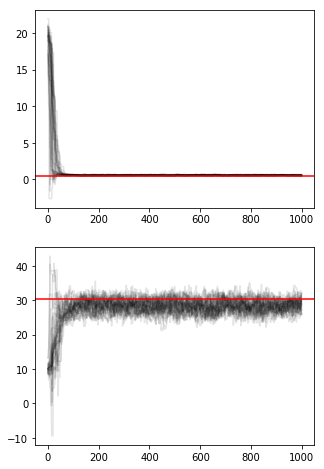

In [8]:
# Plot the trace
fig, ax = plt.subplots(2,1, figsize=(5,8))

# Plot trace
for i in range(2):
    for j in range(nwalkers):
        ax[i].plot(sampler.chain[j,:,i], alpha=0.1, color='k')

    ax[i].axhline(truths[i], color='r')
        
plt.show()


In [9]:
# Reset the sampler, restart the sampler at this current position, which we saved from before and called "pos"
sampler.reset()
pos,prob,state = sampler.run_mcmc(pos, N=1000)

### Show the results

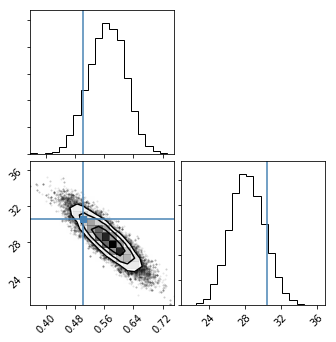

In [10]:
corner.corner(sampler.flatchain, truths=truths)

plt.show()

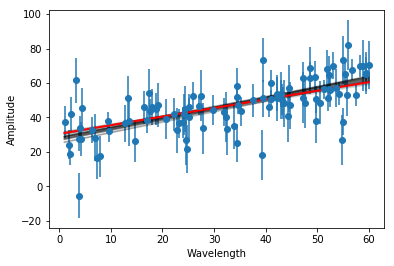

In [12]:
tmp_x = np.linspace(1, 60, 10)

# Plot data points
plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], label='Observations', fmt='o')

# Plot samples
samples = sampler.flatchain[np.random.randint(len(sampler.flatchain), size=30)]
for sample in samples:
    plt.plot(tmp_x, get_val(tmp_x, sample), color='k', alpha=0.15)

# Plot Input values
plt.plot(tmp_x, get_val(tmp_x, truths), color='r', label='Input Model', linewidth=2)

plt.xlabel('Wavelength')
plt.ylabel('Amplitude')

plt.show()

### Now, let's add some censored data

Let's say that your telescope is not sensitive enough to see anything with a magnitude below 35 or above 55. We will do this in a contrived way as an introduction to censored data. See below.

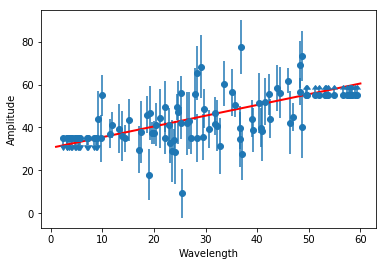

In [13]:
# The input values will be called "truths"
m_truth = 0.5
b_truth = 30.5
truths = m_truth, b_truth

# We will have a wavelength resolution of 1 - We will draw values as before
data = np.zeros((100, 3))
data[:,0] = np.random.uniform(1, 60, size=100)
data[:,2] = np.random.uniform(5, 15, size=100)
data[:,1] = get_val(data[:,0], truths) + np.random.normal(loc=0,scale=data[:,2],size=100)


# Now, we will values in which the line would have given values below 35 and put in separate array
u_limits = np.zeros((len(np.where(get_val(data[:,0], truths)<35)[0]), 2))
u_limits[:,0] = data[get_val(data[:,0], truths)<35,0]
data = data[get_val(data[:,0], truths)>=35,:]
u_limits[:,1] = 35


# Same for values in which the line would have given values above 55 and put in separate array
l_limits = np.zeros((len(np.where(get_val(data[:,0], truths)>55)[0]), 2))
l_limits[:,0] = data[get_val(data[:,0], truths)>55,0]
data = data[get_val(data[:,0], truths)<=55,:]
l_limits[:,1] = 55



# Plot Input values
tmp_x = np.linspace(1, 60, 10)
plt.plot(tmp_x, get_val(tmp_x, truths), color='r', label='Input Model', linewidth=2)

# Plot data points
plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], label='Observations', fmt='o')

# Plot limits
plt.errorbar(u_limits[:,0], u_limits[:,1], yerr=3, uplims=True, color='C0', fmt='o')
plt.errorbar(l_limits[:,0], l_limits[:,1], yerr=3, lolims=True, color='C0', fmt='o')


plt.xlabel('Wavelength')
plt.ylabel('Amplitude')

plt.show()

### Now, we need to adjust the likelihood and posterior functions to include lower and upper limits

How do we do this? To first order, we will do something very simple: we will say that any model inconsistent with the upper and lower limits has a likelihood of 0 (a log likelihood of -infinity). Mathematically, we can separate our observations into three types: $x_{\rm obs}$ (an observations with a data point), $x_{\rm upper}$ (an upper limit), and $x_{\rm low}$ (a lower limit):

\begin{aligned}
P(D|M) &= \\
&= P(\{x_{\rm obs}\}, \{ x_{\rm upper} \}, \{ x_{\rm lower} \} | M) \\
&= \prod_i P(x_{\rm obs,i} | M)\ \prod_i P(x_{\rm upper,i} | M)\ \prod_i P(x_{\rm lower,i} | M) 
\end{aligned}

Since we only care about the log of the likelihood:
$$
\ln P(D|M) = \sum_i \ln P(x_{\rm obs, i} | M)\ + \sum_i \ln P(x_{\rm upper, i} | M) + \sum_i \ln P(x_{\rm lower,i} | M) 
$$

From last week:
$$
\ln P(x_{\rm obs, i} | M) = \frac{-1}{2} \ln \left(2 \pi \sigma_{\rm obs,i}^2\right) + -\frac{(x_{\rm obs,i} - x_{\rm model,i})^2}{2 \sigma_{\rm obs,i}^2} 
$$

Now, we add our upper and lower limits:

$$
\ln P(x_{\rm upper, i} | M) = 
\begin{cases}
0 & x_{\rm upper, i} \geq x_{\rm model, i} \\
-\infty & x_{\rm upper, i} < x_{\rm model, i} \\
\end{cases}
$$

$$
\ln P(x_{\rm lower, i} | M) = 
\begin{cases}
0 & x_{\rm lower, i} \leq x_{\rm model, i} \\
-\infty & x_{\rm lower, i} > x_{\rm model, i} \\
\end{cases}
$$

We combine these into a new likelihood function below. We take lower and upper limits as optional arguments.

In [14]:
def ln_likelihood(p, data, l_limits=None, u_limits=None):
        
    x_vals = data[:,0]
    y_vals = data[:,1]
    y_errs = data[:,2]
    
    y_model = get_val(x_vals, p)
    
    ll = np.sum(-0.5*np.log(2.0*np.pi*y_errs**2)) + np.sum(-(y_model-y_vals)**2 / (2.0*y_errs**2))
    
    if l_limits is not None:
        y_limits = get_val(l_limits[:,0], p)
        if np.any(l_limits[:,1] > y_limits): return -np.inf

    if u_limits is not None:
        y_limits = get_val(u_limits[:,0], p)
        if np.any(u_limits[:,1] < y_limits): return -np.inf
    
    return ll


def ln_posterior(p, data, l_limits=None, u_limits=None):
    
    lp = ln_prior(p)
    if np.isinf(lp): return -np.inf
    
    ll = ln_likelihood(p, data, l_limits, u_limits)
    if np.isinf(ll): return -np.inf

    return lp+ll



### Now, let's generate our initial walker positions and run our model

A few notes. First, we need to generate the walkers in a valid region of parameter space. Second, we now have to pass l_limits and u_limits as arguments to the posterior function.

In [17]:
nwalkers = 32

m_set = np.random.normal(loc=7.0, scale=1.0, size=32)
b_set = np.random.normal(loc=-100.0, scale=1.0, size=32)

p0 = np.array([m_set, b_set]).T

In [18]:
# Create sampler object
sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=2, lnpostfn=ln_posterior, args=(data,l_limits, u_limits))

# Burn-in
pos,prob,state = sampler.run_mcmc(p0, N=1000)

# Actual run
sampler.reset()
pos,prob,state = sampler.run_mcmc(pos, N=1000)

### Plot the trace, covariance in the posterior distribution, and posterior samples

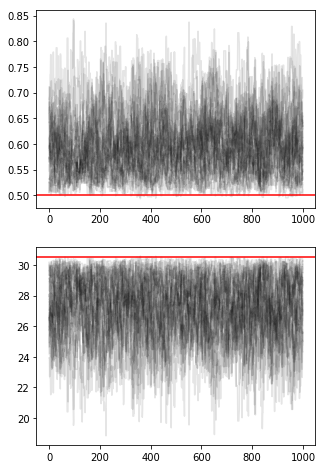

In [19]:
fig, ax = plt.subplots(2,1, figsize=(5,8))

# Plot trace
for i in range(2):
    for j in range(nwalkers):
        ax[i].plot(sampler.chain[j,:,i], alpha=0.1, color='k')


    ax[i].axhline(truths[i], color='r')
    
plt.show()

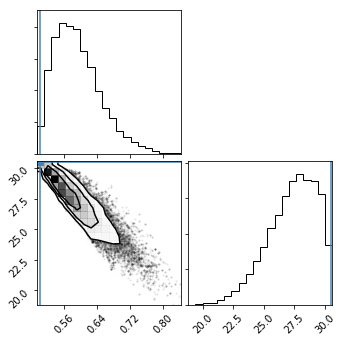

In [20]:
corner.corner(sampler.flatchain, truths=truths)

plt.show()

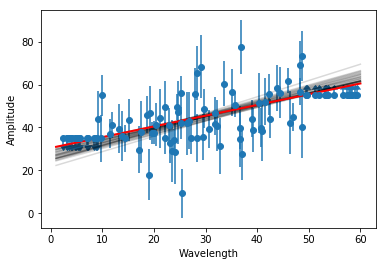

In [21]:
# Plot Input values
tmp_x = np.linspace(1, 60, 10)

# Plot data points
plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], label='Observations', fmt='o')

# Plot limits
plt.errorbar(u_limits[:,0], u_limits[:,1], yerr=3, uplims=True, color='C0', fmt='o')
plt.errorbar(l_limits[:,0], l_limits[:,1], yerr=3, lolims=True, color='C0', fmt='o')

# Plot samples
samples = sampler.flatchain[np.random.randint(len(sampler.flatchain), size=30)]
for sample in samples:
    plt.plot(tmp_x, get_val(tmp_x, sample), color='k', alpha=0.15)


plt.plot(tmp_x, get_val(tmp_x, truths), color='r', label='Input Model', linewidth=2)


plt.xlabel('Wavelength')
plt.ylabel('Amplitude')

plt.show()

### Exercise 1: Notice that the posterior distribution is biased. With your partner, try to explain why.

### Now, let's create a model with outliers

We start by generating a model in which 10% of data are outliers. For simplicity, we will start with only 10 data points.

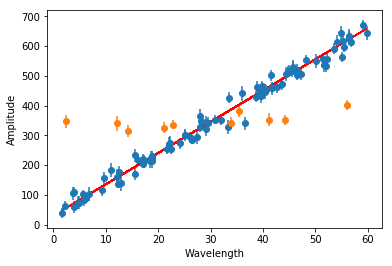

In [22]:
# The input values will be called "truths"
m_truth = 10.5
b_truth = 30.5
mu_b_truth = 350
sigma_b_truth = 20
truths = m_truth, b_truth, mu_b_truth, sigma_b_truth



# We will have a wavelength resolution of 1 - Generate 90 values
data = np.zeros((100, 3))
data[0:90,0] = np.random.uniform(1, 60, size=90)
data[0:90,2] = np.random.uniform(15, 25, size=90)
data[0:90,1] = get_val(data[0:90,0], truths[0:2]) + np.random.normal(loc=0,scale=data[0:90,2],size=90)


# Add 10 outliers from a Gaussian with an amplitude of 90+-2, with measurement uncertainties
data[90:100,0] = np.random.uniform(1, 60, size=10)
data[90:100,2] = np.random.uniform(15, 25, size=10)
data[90:100,1] = np.random.normal(loc=mu_b_truth, scale=sigma_b_truth, size=10) \
                        + np.random.normal(loc=0,scale=data[9:10,2],size=10)


# Plot Input values
plt.plot(data[:,0], get_val(data[:,0], truths[0:2]), color='r', label='Input Model')

# Plot data points
plt.errorbar(data[0:90,0], data[0:90,1], yerr=data[0:90,2], label='Observations', fmt='o')
plt.errorbar(data[90:100,0], data[90:100,1], yerr=data[90:100,2], label='Observations', fmt='o')


plt.xlabel('Wavelength')
plt.ylabel('Amplitude')

plt.show()

### Dealing with this is substantially trickier

We want to come up with a model that can determine if any individual data point is an outlier. To approach this problem, we will go back to our initial model. Before, our model was comprised entirely of two parameters, a slope and an intercept: $x_{\rm model,i}=f(m, b)$. Now we will do something much fancier. We will first model the background as a gaussian with a mean and variance $(\mu_b, \sigma_b)$. We will then add an additional model parameter for *every* data point, $C_{\rm i}$. Our model now includes:

$$
M \equiv \left\{m, b, \mu_b, \sigma_b, \{ C_{\rm i} \} \right\},
$$

where $C$ represents a class index, either a zero (for an outlier) or a one (for a genuine data point). Rather than two parameters, our model now has $4+N$ parameters, where $N$ is the number of observations. This may seem complicated, once we work through it, it will become much clearer.

First, if a data point has $C_{\rm i}=1$, then the likelihood function is exactly as we have seen above:
$$
\ln P(x_{\rm obs, i} | M, C_{\rm i}=1) = \frac{-1}{2} \ln \left(2 \pi \sigma_{\rm obs,i}^2\right) -\frac{(x_{\rm obs,i} - x_{\rm model,i})^2}{2 \sigma_{\rm obs,i}^2} 
$$

If, instead, a data point has $C_{\rm i}=0$, then the likelihood function should follow our model for the background. What does this model look like mathematically? Instead of having a line, we have a Gaussian that is horizontally flat (i.e., no dependence on $x$). So we have data drawn from a Gaussian (with mean $\mu_b$ and variance $\sigma_b^2$), with a Gaussian uncertainty (with mean zero and variance $\sigma_{\rm obs,i}$). This is equivalent to a third Gaussian with mean $\mu_b$ and variance $(\sigma_{\rm obs,i}^2 + \sigma_b^2)$. Our log likelihood function for outliers is very similar to the one above:
$$
\ln P(x_{\rm obs, i} | M, C_{\rm i}=0) = \frac{-1}{2} \ln \left[2 \pi \left(\sigma_{\rm obs,i}^2 + \sigma_b^2 \right)\right] -\frac{(x_{\rm obs,i} - \mu_b)^2}{2 \left( \sigma_{\rm obs,i}^2 + \sigma_b^2 \right)} 
$$

### Let's code our new likelihood function

In [23]:
def ln_prior(p):
    
    
    m, b, mu_b, sigma_b = p[0:4]
    C_set = p[4:]
    
    lp = 0.0
    
    # No priors are actually necessary here, but we can set something just to be rigorous
    # Prior on m
    if m<-1.0e99 or m>1.0e99: return -np.inf
    
    # Prior on b
    if b<-1.0e99 or b>1.0e99: return -np.inf
    
    # Priors on the Gaussian background
    if mu_b < 0.0: return -np.inf
    if sigma_b < 0.0: return -np.inf
    
    # Prior on C_set
    if np.any(C_set < 0.0) or np.any(C_set>2.0): return -np.inf
    
    return lp


def ln_likelihood(p, data):
    
    
    m, b, mu_b, sigma_b = p[0:4]
    C_set = p[4:]
        
    x_vals = data[:,0]
    y_vals = data[:,1]
    y_errs = data[:,2]
    
    y_model = get_val(x_vals, (m,b))
    
    # Data points
    coef = np.ones(len(data))
    coef[C_set<1.0] = 0.0
    ll = np.sum(-coef*0.5*np.log(2.0*np.pi*y_errs**2)) 
    ll += np.sum(-coef*(y_model-y_vals)**2 / (2.0*y_errs**2))

    # Outliers
    coef = np.ones(len(data))
    coef[C_set>1.0] = 0.0
    ll += np.sum(-coef*0.5*np.log(2.0*np.pi*(y_errs**2 + sigma_b**2))) 
    ll += np.sum(-coef*(mu_b-y_vals)**2 / (2.0*(y_errs**2 + sigma_b**2)))

    return ll


def ln_posterior(p, data):
    
    lp = ln_prior(p)
    if np.isinf(lp): return -np.inf
    
    ll = ln_likelihood(p, data)
    
    return lp+ll




In [24]:
nwalkers = 300

m_set = np.random.normal(loc=20.0, scale=1.0, size=nwalkers)
b_set = np.random.normal(loc=10.0, scale=1.0, size=nwalkers)
mu_b_set = np.random.normal(loc=300, scale=1.0, size=nwalkers)
sigma_b_set = np.random.normal(loc=1.0, scale=0.1, size=nwalkers)
#C_set = np.random.uniform(0.0, 2.0, size=(32, 10))
C_set = np.random.normal(1.0, 0.01, size=(nwalkers, 100))

p0 = np.array([m_set, b_set, mu_b_set, sigma_b_set])
p0 = np.vstack([p0, C_set.T]).T

print(p0.shape)

(300, 104)


In [25]:
# Create sampler object
sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=4+len(data), lnpostfn=ln_posterior, args=(data,))

# Burn-in
pos,prob,state = sampler.run_mcmc(p0, N=1000)

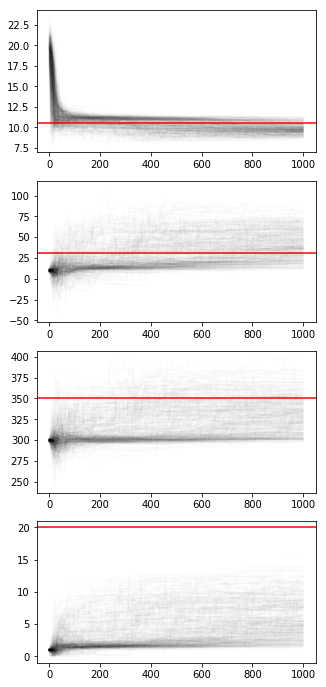

In [26]:
fig, ax = plt.subplots(4,1, figsize=(5,12))

# Plot trace
for i in range(4):
    for j in range(nwalkers):
        ax[i].plot(sampler.chain[j,:,i], alpha=0.01, color='k')

    ax[i].axhline(truths[i], color='r')
plt.show()



### Full run

In [29]:
sampler.reset()
pos,prob,state = sampler.run_mcmc(pos, N=1000)

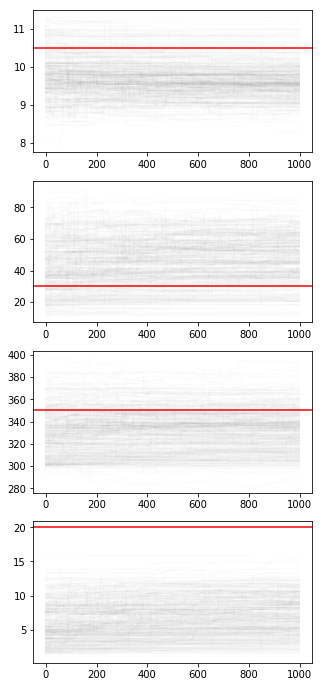

In [30]:
fig, ax = plt.subplots(4,1, figsize=(5,12))

# Plot trace
for i in range(4):
    for j in range(nwalkers):
        ax[i].plot(sampler.chain[j,:,i], alpha=0.01, color='k')

    ax[i].axhline(truths[i], color='r')
plt.show()

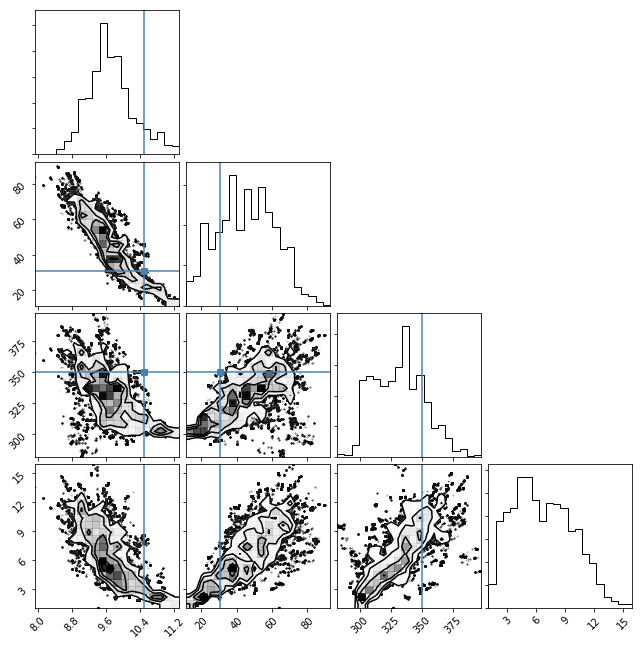

In [31]:
corner.corner(sampler.flatchain[:,0:4], truths=truths)

plt.show()

### Show the distribution of error labels

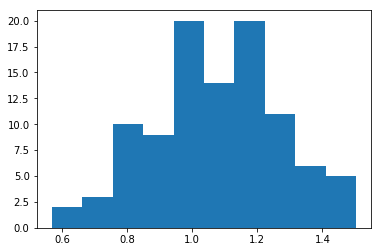

In [32]:
mean = np.zeros(len(data))

for i in range(len(data)):
    
    mean[i] = np.mean(sampler.chain[:,:,i+4])
    
plt.hist(mean)
    
plt.show()

### Use the posterior samples to identify which points are outliers

In [33]:
idx_1 = np.where(mean > 0.8)[0]

idx_2 = np.where(mean < 0.8)[0]

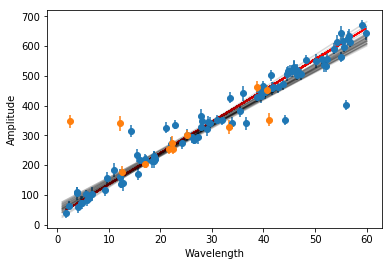

In [34]:

# Plot Input values
plt.plot(data[:,0], get_val(data[:,0], truths[0:2]), color='r', label='Input Model')

# Plot data points
plt.errorbar(data[idx_1,0], data[idx_1,1], yerr=data[idx_1,2], label='Observations', fmt='o', color='C0')
plt.errorbar(data[idx_2,0], data[idx_2,1], yerr=data[idx_2,2], label='Observations', fmt='o', color='C1')
# plt.errorbar(data[0:90,0], data[0:90,1], yerr=data[0:90,2], label='Observations', fmt='o')
# plt.errorbar(data[90:100,0], data[90:100,1], yerr=data[90:100,2], label='Observations', fmt='o')


# Plot samples
tmp_x = np.linspace(1,60,10)
samples = sampler.flatchain[np.random.randint(len(sampler.flatchain), size=30)]
for sample in samples:
    plt.plot(tmp_x, get_val(tmp_x, sample[0:2]), color='k', alpha=0.15)


plt.xlabel('Wavelength')
plt.ylabel('Amplitude')

# plt.ylim(0,120)

plt.show()